# TP1 - Regresión
Notebook inicial para el trabajo práctico.

In [2]:
# 1. Importación de librerías necesarias
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

import holidays

In [3]:
# 2. Carga de datos. Se carga el dataset que contiene los viajes de taxi.
file_path= 'uber_fares.csv'
df = pd.read_csv(file_path)

# visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [38]:
# 3. Análisis descriptivo de las variables
# Comentario: Se realiza un análisis inicial para comprender el comportamiento de cada variable.
# - Descripción estadística (df.describe())
# - Visualización de valores únicos y rangos


# Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns


Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [40]:
df.apply(pd.unique)

key                  [24238194, 27835199, 44984355, 25894730, 17610...
date                 [2015-05-07 19:52:06.0000003, 2009-07-17 20:04...
fare_amount          [7.5, 7.7, 12.9, 5.3, 16.0, 4.9, 24.5, 2.5, 9....
pickup_datetime      [2015-05-07 19:52:06 UTC, 2009-07-17 20:04:56 ...
pickup_longitude     [-73.99981689453125, -73.994355, -74.005043, -...
pickup_latitude      [40.73835372924805, 40.728225, 40.74077, 40.79...
dropoff_longitude    [-73.99951171875, -73.99471, -73.962565, -73.9...
dropoff_latitude     [40.72321701049805, 40.750325, 40.772647, 40.8...
passenger_count                             [1, 3, 5, 2, 4, 6, 0, 208]
dtype: object

In [41]:
df.nunique()

key                  200000
date                 200000
fare_amount            1244
pickup_datetime      196629
pickup_longitude      71066
pickup_latitude       83835
dropoff_longitude     76894
dropoff_latitude      90585
passenger_count           8
dtype: int64

In [4]:
# Eliminar la columna 'key' porque no aporta al análisis
df = df.drop(columns=['key'])

In [5]:
df['pickup_datetime'].isna().sum()

np.int64(0)

In [6]:
# Eliminar la columna 'date' porque redunda con el dato de 'pickup_datetime'
df = df.drop(columns=['date'])

In [7]:
df['passenger_count'].value_counts()

passenger_count
1      138425
2       29428
5       14009
3        8881
4        4276
6        4271
0         709
208         1
Name: count, dtype: int64

In [8]:
# Eliminar filas donde passenger_count sea igual a 208
df = df[df['passenger_count'] != 208]

In [9]:
# PARA ENCONTRAR VALORES NEGATIVOS QUE NO CORRESPONDEN Y MINIMOS ABSURDOS
df['fare_amount'].value_counts().sort_index().head(20)

fare_amount
-52.00      2
-50.50      1
-49.57      1
-23.70      1
-10.90      1
-7.30       1
-6.90       1
-5.70       1
-5.50       1
-5.00       1
-3.50       3
-3.30       1
-3.00       2
 0.00       5
 0.01       2
 0.11       1
 2.50     825
 2.60       1
 2.90     478
 3.00     355
Name: count, dtype: int64

Eliminamos los siguientes datos considerados erroneos:
- Fare 0
- Fare 0.01 y 0.11 tambien eliminar ya que no se corresponden a la distancia recorrida
- Todos los fare negativos tambien se eliminan

In [10]:
# Eliminar filas donde fare_amount sea menor o igual a 0.11
df = df[df['fare_amount'] > 0.11]

In [11]:
# Verificar si hay valores NaN en fare__amount
df['fare_amount'].isna().sum()

np.int64(0)

Para lograr determinar si un fare amount grande es un outlier necesitamos calcular la variable distancia para lograr comprender si se corresponden los valores o no. Luego de una evaluación de la mejor función de distancia, llegamos a la conclusión que la manhattan se ajusta mejor a la estructura de la ciudad en estudio.

In [12]:
# Distancia Manhattan
def distancia_absoluta(lat1, lon1, lat2, lon2):
    """
    Calcula la suma de las diferencias absolutas entre latitud y longitud.
    Es decir, la distancia Manhattan en coordenadas.
    """
    return np.abs(lat2 - lat1) + np.abs(lon2 - lon1)

# Creamos al columna distancia
df["distancia_recorrida"] = distancia_absoluta(
    df["pickup_latitude"], df["pickup_longitude"],
    df["dropoff_latitude"], df["dropoff_longitude"]
)

# Distancia Manhattan en kilómetros (aproximado)
df["distancia_recorrida_km"] = df["distancia_recorrida"] * 111

# Haversine
# Distancia haversine (en km)
def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en km
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

df['dist_haversine'] = haversine(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude'])

In [13]:
df['fare_amount'].value_counts().sort_index().tail(20)

fare_amount
163.00    1
165.00    1
165.33    1
170.00    1
171.35    1
180.00    1
183.00    1
190.00    1
190.83    1
191.80    1
192.33    1
196.00    1
200.00    1
206.38    1
220.00    1
230.00    1
250.00    1
275.00    1
350.00    1
499.00    1
Name: count, dtype: int64

In [14]:
df.nlargest(20, 'fare_amount')[['fare_amount', 'distancia_recorrida', 'distancia_recorrida_km', 'dist_haversine']]

,fare_amount,distancia_recorrida,distancia_recorrida_km,dist_haversine
170081,499.00,0.000011,0.001221,0.000790
4292,350.00,0.000000,0.000000,0.000000
185325,275.00,0.000000,0.000000,0.000000
71715,250.00,0.000000,0.000000,0.000000
197493,230.00,0.501812,55.701132,37.989067
29261,220.00,0.035656,3.957816,2.914493
23682,206.38,0.858774,95.323914,60.100889
196647,200.00,0.000000,0.000000,0.000000
184901,196.00,0.000017,0.001887,0.001259
33911,192.33,0.000000,0.000000,0.000000


In [15]:
# Eliminar viajes con distancia recorrida menor a 0.1 km
df = df[df['distancia_recorrida_km'] >= 0.1]

In [16]:
df.sort_values('fare_amount', ascending=False)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine
197493,230.00,2014-09-07 08:39:00 UTC,-73.937765,40.758267,-74.382200,40.700890,2,0.501812,55.701132,37.989067
29261,220.00,2013-09-27 12:36:11 UTC,-73.801147,40.671653,-73.790402,40.646742,1,0.035656,3.957816,2.914493
23682,206.38,2014-11-02 22:40:20 UTC,-73.782161,40.644601,-74.449079,40.836457,1,0.858774,95.323914,60.100889
39716,191.80,2012-06-26 22:28:00 UTC,-73.822978,40.788500,-73.548110,41.045037,1,0.531405,58.985955,36.703299
114282,190.83,2015-04-04 23:59:34 UTC,-73.781746,40.644630,-74.320007,40.716450,1,0.610081,67.718960,46.086169
...,...,...,...,...,...,...,...,...,...,...
47911,2.50,2012-06-24 19:41:15 UTC,-73.985996,40.743394,-73.985372,40.744158,1,0.001388,0.154068,0.099902
147851,2.50,2015-06-16 10:32:26 UTC,-73.969704,40.755325,-73.968933,40.755070,1,0.001026,0.113903,0.070855
12432,2.50,2014-03-26 13:31:11 UTC,-73.954993,40.765505,0.000000,0.000000,1,114.720498,12733.975278,8663.923601
40290,2.50,2013-10-16 18:14:00 UTC,0.000000,0.000000,-74.043428,40.788097,6,114.831525,12746.299275,8671.705316


In [17]:
# Eliminar columnas de pickup y dropoff (latitud y longitud)
df = df.drop(columns=[
    'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude'
])

In [18]:
# Resetear los índices del DataFrame después de los filtrados
df = df.reset_index(drop=True)
df

,fare_amount,pickup_datetime,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine
0,7.5,2015-05-07 19:52:06 UTC,1,0.015442,1.714050,1.683323
1,7.7,2009-07-17 20:04:56 UTC,1,0.022455,2.492505,2.457590
2,12.9,2009-08-24 21:45:00 UTC,1,0.074355,8.253405,5.036377
3,5.3,2009-06-26 08:22:21 UTC,3,0.023313,2.587743,1.661683
4,16.0,2014-08-28 17:47:00 UTC,5,0.065221,7.239531,4.475450
...,...,...,...,...,...,...
193360,3.0,2012-10-28 10:49:00 UTC,1,0.001447,0.160617,0.112210
193361,7.5,2014-03-14 01:09:00 UTC,1,0.024733,2.745363,1.875050
193362,30.9,2009-06-29 00:42:00 UTC,2,0.190959,21.196449,12.850319
193363,14.5,2015-05-20 14:56:25 UTC,1,0.043945,4.877930,3.539715


In [19]:
# Crear objeto de feriados de New York
feriados = holidays.US(state='NY')

# Si pickup_datetime es string, primero conviértelo a datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Crear la variable dummy: 1 si es feriado, 0 si no
df['es_feriado'] = df['pickup_datetime'].dt.date.apply(lambda x: 1 if x in feriados else 0)

# Crear variable dummy: 1 si es fin de semana (sábado o domingo), 0 si es día de semana (lunes a viernes)
df['es_fin_de_semana'] = df['pickup_datetime'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

# Crear variable: 1 si es fin de semana o feriado, 0 si es día de semana y no feriado
df['es_no_laborable'] = ((df['es_fin_de_semana'] == 1) | (df['es_feriado'] == 1)).astype(int)

# Dropear columnas auxiliares
df = df.drop(columns=['es_feriado', 'es_fin_de_semana'])

df

,fare_amount,pickup_datetime,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable
0,7.5,2015-05-07 19:52:06+00:00,1,0.015442,1.714050,1.683323,0
1,7.7,2009-07-17 20:04:56+00:00,1,0.022455,2.492505,2.457590,0
2,12.9,2009-08-24 21:45:00+00:00,1,0.074355,8.253405,5.036377,0
3,5.3,2009-06-26 08:22:21+00:00,3,0.023313,2.587743,1.661683,0
4,16.0,2014-08-28 17:47:00+00:00,5,0.065221,7.239531,4.475450,0
...,...,...,...,...,...,...,...
193360,3.0,2012-10-28 10:49:00+00:00,1,0.001447,0.160617,0.112210,1
193361,7.5,2014-03-14 01:09:00+00:00,1,0.024733,2.745363,1.875050,0
193362,30.9,2009-06-29 00:42:00+00:00,2,0.190959,21.196449,12.850319,0
193363,14.5,2015-05-20 14:56:25+00:00,1,0.043945,4.877930,3.539715,0


In [20]:
# Crear variable 'hora_del_dia' (0 a 23) a partir de pickup_datetime
df['hora_del_dia'] = df['pickup_datetime'].dt.hour
df.head()

,fare_amount,pickup_datetime,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable,hora_del_dia
0,7.5,2015-05-07 19:52:06+00:00,1,0.015442,1.714050,1.683323,0,19
1,7.7,2009-07-17 20:04:56+00:00,1,0.022455,2.492505,2.457590,0,20
2,12.9,2009-08-24 21:45:00+00:00,1,0.074355,8.253405,5.036377,0,21
3,5.3,2009-06-26 08:22:21+00:00,3,0.023313,2.587743,1.661683,0,8
4,16.0,2014-08-28 17:47:00+00:00,5,0.065221,7.239531,4.475450,0,17


In [21]:
# Crear variables dummies según el día del mes de pickup_datetime
df['1era_mitad_mes'] = (df['pickup_datetime'].dt.day < 15).astype(int)
df['2da_mitad_mes'] = (df['pickup_datetime'].dt.day >= 15).astype(int)
df

,fare_amount,pickup_datetime,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable,hora_del_dia,1era_mitad_mes,2da_mitad_mes
0,7.5,2015-05-07 19:52:06+00:00,1,0.015442,1.714050,1.683323,0,19,1,0
1,7.7,2009-07-17 20:04:56+00:00,1,0.022455,2.492505,2.457590,0,20,0,1
2,12.9,2009-08-24 21:45:00+00:00,1,0.074355,8.253405,5.036377,0,21,0,1
3,5.3,2009-06-26 08:22:21+00:00,3,0.023313,2.587743,1.661683,0,8,0,1
4,16.0,2014-08-28 17:47:00+00:00,5,0.065221,7.239531,4.475450,0,17,0,1
...,...,...,...,...,...,...,...,...,...,...
193360,3.0,2012-10-28 10:49:00+00:00,1,0.001447,0.160617,0.112210,1,10,0,1
193361,7.5,2014-03-14 01:09:00+00:00,1,0.024733,2.745363,1.875050,0,1,1,0
193362,30.9,2009-06-29 00:42:00+00:00,2,0.190959,21.196449,12.850319,0,0,0,1
193363,14.5,2015-05-20 14:56:25+00:00,1,0.043945,4.877930,3.539715,0,14,0,1


In [22]:
# Crear variables senoidales a partir de hora_del_dia
df['hora_sin'] = np.sin(2 * np.pi * df['hora_del_dia'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['hora_del_dia'] / 24)
df = df.drop(columns=['pickup_datetime'])
df.head()

,fare_amount,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable,hora_del_dia,1era_mitad_mes,2da_mitad_mes,hora_sin,hora_cos
0,7.5,1,0.015442,1.714050,1.683323,0,19,1,0,-0.965926,0.258819
1,7.7,1,0.022455,2.492505,2.457590,0,20,0,1,-0.866025,0.500000
2,12.9,1,0.074355,8.253405,5.036377,0,21,0,1,-0.707107,0.707107
3,5.3,3,0.023313,2.587743,1.661683,0,8,0,1,0.866025,-0.500000
4,16.0,5,0.065221,7.239531,4.475450,0,17,0,1,-0.965926,-0.258819


In [23]:
# Crear variables dummies para passenger_count
df['delivery'] = (df['passenger_count'] == 0).astype(int)
df['standard'] = df['passenger_count'].between(1, 4).astype(int)
df['xl'] = (df['passenger_count'] > 4).astype(int)
df.head()

,fare_amount,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable,hora_del_dia,1era_mitad_mes,2da_mitad_mes,hora_sin,hora_cos,delivery,standard,xl
0,7.5,1,0.015442,1.714050,1.683323,0,19,1,0,-0.965926,0.258819,0,1,0
1,7.7,1,0.022455,2.492505,2.457590,0,20,0,1,-0.866025,0.500000,0,1,0
2,12.9,1,0.074355,8.253405,5.036377,0,21,0,1,-0.707107,0.707107,0,1,0
3,5.3,3,0.023313,2.587743,1.661683,0,8,0,1,0.866025,-0.500000,0,1,0
4,16.0,5,0.065221,7.239531,4.475450,0,17,0,1,-0.965926,-0.258819,0,0,1


In [24]:
df = df.drop(columns=['passenger_count'])

In [25]:
df = df.drop(columns=['hora_del_dia'])


In [26]:
df

,fare_amount,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable,1era_mitad_mes,2da_mitad_mes,hora_sin,hora_cos,delivery,standard,xl
0,7.5,0.015442,1.714050,1.683323,0,1,0,-0.965926,0.258819,0,1,0
1,7.7,0.022455,2.492505,2.457590,0,0,1,-0.866025,0.500000,0,1,0
2,12.9,0.074355,8.253405,5.036377,0,0,1,-0.707107,0.707107,0,1,0
3,5.3,0.023313,2.587743,1.661683,0,0,1,0.866025,-0.500000,0,1,0
4,16.0,0.065221,7.239531,4.475450,0,0,1,-0.965926,-0.258819,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
193360,3.0,0.001447,0.160617,0.112210,1,0,1,0.500000,-0.866025,0,1,0
193361,7.5,0.024733,2.745363,1.875050,0,1,0,0.258819,0.965926,0,1,0
193362,30.9,0.190959,21.196449,12.850319,0,0,1,0.000000,1.000000,0,1,0
193363,14.5,0.043945,4.877930,3.539715,0,0,1,-0.500000,-0.866025,0,1,0


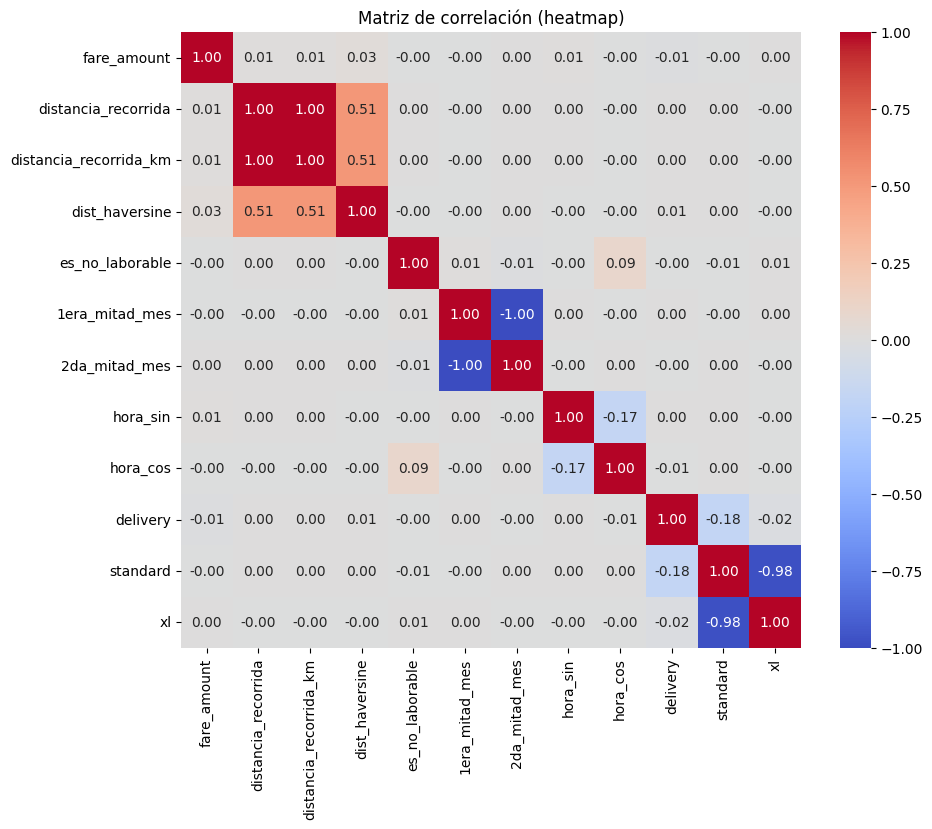

In [27]:
# Calcular la matriz de correlación antes de graficar
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación (heatmap)')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

# Modelo 1: Solo distancia recorrida en km como predictor
y = df["fare_amount"]
X = df.drop(columns=["fare_amount"])

# Split de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar solo 'distancia_recorrida_km' y 'dist_haversine'
cols_to_scale = ['distancia_recorrida_km', 'dist_haversine']

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Modelos con todas las variables además de la principal
X_km_train = X_train.drop(columns=["dist_haversine"])
X_km_test = X_test.drop(columns=["dist_haversine"])

X_hav_train = X_train.drop(columns=["distancia_recorrida_km"])
X_hav_test = X_test.drop(columns=["distancia_recorrida_km"])

# Modelo 1: Regresión lineal con distancia_recorrida_km
modelo_km = LinearRegression()
modelo_km.fit(X_km_train, y_train)
y_pred_km = modelo_km.predict(X_km_test)

# Modelo 2: Regresión lineal con dist_haversine
modelo_hav = LinearRegression()
modelo_hav.fit(X_hav_train, y_train)
y_pred_hav = modelo_hav.predict(X_hav_test)

# Evaluación simple
from sklearn.metrics import mean_squared_error, r2_score

print("Modelo con distancia_recorrida_km")
print("MSE:", mean_squared_error(y_test, y_pred_km))
print("R2:", r2_score(y_test, y_pred_km))

print("\nModelo con dist_haversine")
print("MSE:", mean_squared_error(y_test, y_pred_hav))
print("R2:", r2_score(y_test, y_pred_hav))

Modelo con distancia_recorrida_km
MSE: 89.66499863978636
R2: 0.0004920216660120325

Modelo con dist_haversine
MSE: 89.65376341403706
R2: 0.0006172622609506018


In [30]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

In [ ]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

In [ ]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

In [32]:
# Ejemplo de reshape para cada conjunto de datos, útil si solo usás una variable predictora (columna)
X_km_train_rs = X_km_train.values.reshape(-1, 1)
y_train_rs = y_train.values.reshape(-1, 1)
X_km_test_rs = X_km_test.values.reshape(-1, 1)
y_test_rs = y_test.values.reshape(-1, 1)

X_hav_train_rs = X_hav_train.values.reshape(-1, 1)
X_hav_test_rs = X_hav_test.values.reshape(-1, 1)

In [33]:
gradient_descent(X_km_train_rs, y_train_rs, X_km_test_rs, y_test_rs, lr=0.01, epochs=100)

ValueError: operands could not be broadcast together with shapes (154692,1) (1546920,1) 

In [ ]:
gradient_descent(X_hav_train_rs, y_train_rs, X_hav_test_rs, y_test_rs, lr=0.01, epochs=100)

# Ingeniería de Variables para Análisis de Viajes en Taxi

## 1. Creación de Variables Derivadas

### Distancia entre Origen y Destino
- **Distancia Euclidiana**: Calculada en grados entre dos puntos. Es rápida de calcular, aunque no representa la ruta real sobre la superficie terrestre.
- **Distancia Haversine**: Calculada en kilómetros o metros, es una medida más precisa para coordenadas geográficas, considerando la curvatura de la Tierra.
- **Distancia Absoluta (Manhattan)**: Suma de las diferencias absolutas de latitud y longitud, útil para aproximar trayectos en ciudades con calles en cuadrícula (como Manhattan).

### Características Temporales del Viaje
Extraídas a partir de `pickup_datetime`:
- **Hora del día** (`0-23`): Permite analizar si el horario influye en la tarifa.
- **Día de la semana** (`Lunes` a `Domingo`): Útil para detectar diferencias entre días laborables y fines de semana.
- **Semana del año**: Puede ayudar a detectar patrones estacionales o eventos especiales.
- **Mes** o **Estación del año**: Para analizar estacionalidad en la demanda.
- **¿Es hora pico?**: Variable booleana según franjas horarias (ej.: 7-9 AM y 5-7 PM).
- **¿Es fin de semana?**: Variable booleana para diferenciar sábados y domingos.

### Duración del Viaje
- Si se dispone del tiempo de llegada, calcular la duración real.
- Si no, **estimar la duración** utilizando la distancia y una velocidad promedio (ejemplo: duración = distancia / velocidad promedio).

### Variables de Interacción
- **Distancia × Cantidad de Pasajeros**: Para observar si viajes largos con más pasajeros modifican la tarifa por persona.
- **Hora × Día de la semana**: Permite captar efectos combinados entre horario y tipo de día.

---

## 2. Identificación y Tratamiento de Datos Problemáticos

### Valores Atípicos (Outliers)
- Detectar valores extremos en variables como distancia, tarifa o cantidad de pasajeros.
- Analizar si tienen sentido físico (ej.: viajes con distancia cero pero tarifa alta).

### Datos Faltantes (Missing Values)
- Identificar columnas con valores faltantes.
- Decidir el tratamiento adecuado: imputación, eliminación, o reemplazo según el caso.

---

### Notas
- Las variables temporales pueden codificarse como **cualitativas ordinales** para ciertos modelos (ej.: día de la semana, semana del año).
- La ingeniería de variables adecuada puede mejorar significativamente el rendimiento de los modelos de regresión y la interpretación de los resultados.

In [ ]:
# 4. Análisis y tratamiento de datos faltantes
# Comentario: Se identifican valores faltantes y se decide cómo tratarlos (eliminación, imputación, etc.).
# - df.isnull().sum()
# - Justificación de la decisión tomada

In [ ]:
# 5. Análisis y tratamiento de datos atípicos (outliers)
# Comentario: Se detectan y tratan valores atípicos en las variables numéricas.
# - Visualización con boxplots
# - Decisión sobre el tratamiento (eliminación, ajuste, etc.)

In [ ]:
# 6. Visualización de datos
# Comentario: Se grafican histogramas y scatterplots para analizar la distribución y relaciones entre variables.
# - Histograma de cada variable
# - Scatterplots entre variables relevantes
# - Diagramas de caja

In [ ]:
# 7. Codificación de variables categóricas (si corresponde)
# Comentario: Se codifican variables categóricas para su uso en modelos (OneHotEncoder, LabelEncoder, etc.).
# - Ejemplo: df['var'] = ...

In [ ]:
# 8. Matriz de correlación
# Comentario: Se calcula la matriz de correlación para analizar dependencias entre variables.
# - sns.heatmap(df.corr(), annot=True)

In [ ]:
# 9. Estandarización o escalado de datos
# Comentario: Se aplican técnicas de escalado para mejorar el desempeño de los modelos.
# - StandardScaler, MinMaxScaler, etc.

In [ ]:
# 10. División de datos: Train-Test (y opcionalmente Validación)
# Comentario: Se divide el conjunto de datos en entrenamiento y prueba.
# - from sklearn.model_selection import train_test_split
# - X_train, X_test, y_train, y_test = train_test_split(...)

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='fare_amount'), df['fare_amount'], test_size=0.2, random_state=42)

In [ ]:
X_train.describe()

In [ ]:
# 11. Implementación de modelos de regresión
# 11.a. Regresión lineal múltiple (LinearRegression)
# Comentario: Se ajusta el modelo base de regresión lineal.

In [ ]:
# 11.b. Métodos de gradiente descendente (SGDRegressor, otros)
# Comentario: Se prueban diferentes variantes de gradiente descendente.
# - Se grafican errores vs iteraciones (loss vs epochs)

In [ ]:
# 11.c. Métodos de regularización (Lasso, Ridge, Elastic Net)
# Comentario: Se aplican modelos con regularización y se varía el coeficiente.
# - Se comparan métricas para distintos valores de alpha.

In [ ]:
# 12. Evaluación de modelos: métricas de regresión
# Comentario: Se calculan las métricas elegidas para train y test (R2, MSE, RMSE, MAE, MAPE).
# - Justificación de las métricas utilizadas

In [ ]:
# 13. Gráficos de residuos
# Comentario: Se grafican los residuos para analizar el ajuste de los modelos.


In [ ]:
# 14. Análisis de fitting y conclusiones intermedias
# Comentario: Se analiza el fitting del modelo y se discuten los efectos de la regularización y gradiente descendente.


In [ ]:
# 15. Optimización y comparación de hiperparámetros
# Comentario: Se varían los hiperparámetros y se observa el efecto en el desempeño del modelo.
# - GridSearchCV, RandomizedSearchCV, o análisis manual


In [ ]:
# 16. Comparación de modelos
# Comentario: Se compara el desempeño de los distintos modelos y se selecciona el mejor.
# - Justificación de la métrica de comparación